### Preloads

In [ ]:
from IPython.display import clear_output
import time
import logging
import warnings
logging.basicConfig(level=logging.ERROR)
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ! mkdir -p plots/EMG
# ! mkdir -p plots/GSR
# ! mkdir -p plots/Resp
# ! mkdir -p plots/ECG
! mkdir -p plots/physiological_analysis

In [ ]:
! pip3 install mne
! pip3 install neurokit2
time.sleep(0.1)
clear_output()

print(f" ")

In [ ]:

import os
import sys

import joblib
import gc

from tqdm import tqdm

import mne
import numpy as np
from scipy.signal import resample
from scipy.fft import fft, fftfreq
from scipy.interpolate import CubicSpline

import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style("whitegrid")

import shutil
from google.colab import files

In [ ]:
mne.set_log_level('ERROR')

In [ ]:
phases = ['pre_rest', 'stimulus1', 'stimulus2', 'stimulus3', 'post_rest']
stimuli_phases = phases[1:-1]
rest_phases = ['pre_rest', 'post_rest']

In [ ]:
import functions as fnc
from functions import TIME_WINDOW, PLOT_TIME_WINDOW, CHILLS_REPORT_WINDOW
from functions import PREPROCESSED_DIR, FEATURES_DIR, DATASET_DIR

In [ ]:
PROCESSED_DIR = "drive/MyDrive/chills_dataset/processed"

### Predefs

In [ ]:
# @title Analysis Parameters

window = 0.05
select_channel = {"gsr":0, "emg":1, "resp":2, "ecg":3}

In [ ]:
# @title Functions

def stack_event_epochs(_signals, sub_phase, phases):
  if (sub_phase is not None) and (sub_phase != "pre_post"):
    _array = np.empty((0, int(fs*PLOT_TIME_WINDOW), 4))
  elif sub_phase=="pre_post":
    _array = np.empty((0, 2*int(fs*PLOT_TIME_WINDOW), 4))
  else:
    _array = np.empty((0, 2*int(fs*(PLOT_TIME_WINDOW)), 4))

  for subject in tqdm(_signals, desc="Generating Epochs", total=len(_signals)):
    for phase in phases:

      if (sub_phase is not None) and (phase in stimuli_phases):
        for epoch in _signals[subject][phase]:
            if sub_phase in epoch:

              if sub_phase=="pre_post":
                if epoch[sub_phase].shape[0] != 2*int(fs*PLOT_TIME_WINDOW):
                  old_fs = epoch[sub_phase].shape[0] / (2*PLOT_TIME_WINDOW)
                  n_sample = int(epoch[sub_phase].shape[0] * (fs/old_fs))
                  resampled_epoch = resample(epoch[sub_phase], n_sample, axis=0)
                  _array = np.vstack((_array, np.expand_dims(resampled_epoch, 0)))
                else:
                  _array = np.vstack((_array, np.expand_dims(epoch[sub_phase], 0)))
                continue

              if epoch[sub_phase].shape[0] != int(fs*PLOT_TIME_WINDOW) and sub_phase!="pre_post":
                old_fs = epoch[sub_phase].shape[0] / PLOT_TIME_WINDOW
                n_sample = int(epoch[sub_phase].shape[0] * (fs/old_fs))
                resampled_epoch = resample(epoch[sub_phase], n_sample, axis=0)
                _array = np.vstack((_array, np.expand_dims(resampled_epoch, 0)))
                continue

              _array = np.vstack((_array, np.expand_dims(epoch[sub_phase], 0)))
      else:
        if phase not in phases:
          continue
        for data in _signals[subject][phase]:
          old_fs = data.shape[0] / 300
          if old_fs != fs:
            n_sample = int(data.shape[0] * (fs/old_fs))
            resampled_data = resample(data, n_sample, axis=0)
            data = resampled_data

          T, _ = data.shape
          epoch_length = 2*int(PLOT_TIME_WINDOW*fs)
          num_epochs = T // epoch_length
          overlap = int(0.1*epoch_length)
          step_size = epoch_length - overlap

          for i in range(num_epochs):
            start_idx = i*step_size
            end_idx = start_idx+epoch_length
            if end_idx>T:
                break
            arr = data[start_idx:end_idx, :]
            _array = np.vstack((_array, np.expand_dims(arr, 0)))

  return _array

def m_avg(arr, perc, pad_mode="symmetric"):
    window_size = int(len(arr) * perc)
    if window_size % 2 == 0:
        window_size += 1  # Ensure window size is odd for better alignment

    kernel = np.ones(window_size) / window_size

    # Pad the array symmetrically to avoid corner effects
    pad_width = window_size // 2
    arr_padded = np.pad(arr, pad_width, mode=pad_mode)

    # Convolve with the padded array
    smoothed = np.convolve(arr_padded, kernel, mode='valid')

    return smoothed

import numpy as np

def crossfade(pre_chill, post_chill, fs, time_window, overlap=0.2):
    """
    Smoothly transitions between pre_chill and post_chill signals using a crossfade.

    Parameters:
    - pre_chill (ndarray): Signal before the chill event, shape (N, channels)
    - post_chill (ndarray): Signal after the chill event, shape (M, channels)
    - fs (int): Sampling frequency (Hz)
    - time_window (float): Total window duration in seconds
    - overlap (float): Fraction of time_window to use for crossfade (default: 20%)

    Returns:
    - smooth_signal (ndarray): The recombined signal with a smooth transition
    """
    n_samples = int(fs * time_window)
    overlap_samples = int(overlap * n_samples)  # Number of samples to overlap

    # Ensure both signals have at least n_samples
    pre_chill = pre_chill[-n_samples:]
    post_chill = post_chill[:n_samples]

    # Ensure correct shapes
    min_channels = min(pre_chill.shape[1], post_chill.shape[1])
    pre_chill = pre_chill[:, :min_channels]
    post_chill = post_chill[:, :min_channels]

    # Define fade weights
    fade_out = np.linspace(1, 0, overlap_samples).reshape(-1, 1)
    fade_in = np.linspace(0, 1, overlap_samples).reshape(-1, 1)

    # Apply crossfade
    transition_zone = (fade_out * pre_chill[-overlap_samples:]) + (fade_in * post_chill[:overlap_samples])

    # Concatenate the smoothly blended signals
    smooth_signal = np.vstack((pre_chill[:-overlap_samples], transition_zone, post_chill[overlap_samples:]))

    return smooth_signal

def add_pre_post_subphase(_signals, overlap_=0.2):
  for s, subject in tqdm(enumerate(_signals), desc="Generating Epochs", total=len(_signals)):
    for phase in stimuli_phases:
      if phase not in phases:
        continue
      for e, epoch in enumerate(_signals[subject][phase]):
        if "post" not in epoch:
          continue

        fs_ = epoch["post"].shape[0] / PLOT_TIME_WINDOW
        if fs_!=fs:
          n_sample = int(epoch["post"].shape[0] * (fs/fs_))
          post = resample(epoch["post"], n_sample, axis=0)
        else:
          post = epoch["post"]

        if "pre" in epoch:
          if fs != fs_:
            n_sample = int(epoch["pre"].shape[0] * (fs/fs_))
            pre = resample(epoch["pre"], n_sample, axis=0)
          else:
            pre = epoch["pre"]
        else:
          pre = np.mean(post, axis=0)
          pre = np.tile(pre, (post.shape[0], 1))
          # post = post

        # smoothed_signal = crossfade(pre, post, fs, PLOT_TIME_WINDOW*2, overlap=overlap_)

        _signals[subject][phase][e]["pre_post"] = np.vstack((pre[:, :], post[:, :]))
        # _signals[subject][phase][e]["pre_post"] = smoothed_signal

  return _signals

def minmax_scale(x, axis_=0):
  min_vals = np.min(x, axis=axis_, keepdims=True)  # Min along T-axis
  max_vals = np.max(x, axis=axis_, keepdims=True)  # Max along T-axis

  range_vals = max_vals - min_vals
  range_vals[range_vals == 0] = 1  # Avoid division by zero

  return (x - min_vals) / range_vals

In [ ]:
# @title Load Signals

PROCESSED_DIR = "drive/MyDrive/chills_dataset/processed"

organic_chills = joblib.load(os.path.join(PROCESSED_DIR, "organic_chills_signal.sav"))
augmented_chills = joblib.load(os.path.join(PROCESSED_DIR, "augmented_chills_signal.sav"))
simulated_chills = joblib.load(os.path.join(PROCESSED_DIR, "simulated_chills_signal.sav"))
non_chills = joblib.load(os.path.join(PROCESSED_DIR, "non_chills_signal.sav"))

organic_chills_frisson_on = {}
organic_chills_frisson_off = {}
non_chills_pre_rest = {}
non_chills_post_rest = {}

for subject in organic_chills.keys():
  if int(subject)%2 != 0:
    organic_chills_frisson_off[subject] = organic_chills[subject]
  else:
    organic_chills_frisson_on[subject] = organic_chills[subject]

  if len(non_chills[subject]["pre_rest"])>0:
    non_chills_pre_rest[subject] = {"pre_rest": non_chills[subject]["pre_rest"]}
  if len(non_chills[subject]["post_rest"])>0:
    non_chills_post_rest[subject] = {"post_rest": non_chills[subject]["post_rest"]}

fs = 500
organic_chills_frisson_on = add_pre_post_subphase(organic_chills_frisson_on)
organic_chills_frisson_off = add_pre_post_subphase(organic_chills_frisson_off)
augmented_chills = add_pre_post_subphase(augmented_chills)
simulated_chills = add_pre_post_subphase(simulated_chills)

frisson_on_epochs = stack_event_epochs(organic_chills_frisson_on, "pre_post", stimuli_phases)
frisson_off_epochs = stack_event_epochs(organic_chills_frisson_off, "pre_post", stimuli_phases)
augmented_epochs = stack_event_epochs(augmented_chills, "pre_post", stimuli_phases)
simulated_epochs = stack_event_epochs(simulated_chills, "pre_post", stimuli_phases)
pre_rest_epochs = stack_event_epochs(non_chills_pre_rest, None, ["pre_rest"])
post_rest_epochs = stack_event_epochs(non_chills_post_rest, None, ["post_rest"])

(frisson_on_epochs.shape, frisson_off_epochs.shape), augmented_epochs.shape, simulated_epochs.shape, (pre_rest_epochs.shape, post_rest_epochs.shape)

Generating Epochs: 100%|██████████| 96/96 [00:48<00:00,  1.99it/s]


(((429, 30000, 4), (393, 30000, 4)),
 (6, 30000, 4),
 (36, 30000, 4),
 ((170, 30000, 4), (480, 30000, 4)))

## Analysis 1
- *Subset 1: Organic Chills Comparison (FRISSON-ON vs FRISSON-OFF)*
- *Subser 2: Compare Organic Chills to Non-Chills*
- *Subset 3: Compare Organic, Augmented and Simulated Chills*

### Subset 1

In [ ]:
window = 0.01
frisson_on = np.apply_along_axis(lambda x: m_avg(x, window), axis=1, arr=frisson_on_epochs)
frisson_off = np.apply_along_axis(lambda x: m_avg(x, window), axis=1, arr=frisson_off_epochs)

frisson_on = minmax_scale(frisson_on, 1)
frisson_off = minmax_scale(frisson_off, 1)

frisson = np.vstack((frisson_on, frisson_off))
frisson_on.shape, frisson_off.shape, frisson.shape

((429, 30000, 4), (393, 30000, 4), (822, 30000, 4))

#### Time Domain

In [ ]:
frisson_on_mean = frisson_on.mean(axis=0)
frisson_off_mean = frisson_off.mean(axis=0)
frisson_mean = frisson.mean(axis=0)

frisson_on_std = frisson_on.std(axis=0) / len(frisson_on)**0.5
frisson_off_std = frisson_off.std(axis=0) / len(frisson_off)**0.5
frisson_std = frisson.std(axis=0) / len(frisson)**0.5

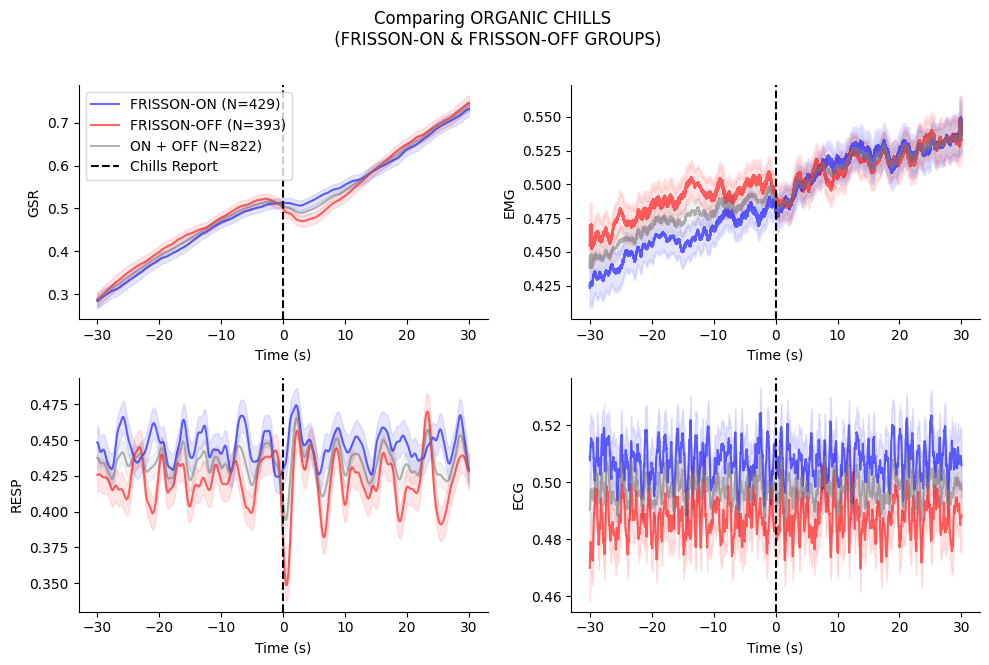

In [ ]:
fig, ax_ = plt.subplots(2, 2, figsize=(10, 6))
ax = ax_.flatten()

for sensor in ["gsr", "emg", "resp", "ecg"]:
  ch = select_channel[sensor]

  y = frisson_on_mean[:, ch].T
  y_std = frisson_on_std[:, ch]
  ax[ch].plot(np.arange(-30, 30, 1/fs), y, label=f"FRISSON-ON (N={len(frisson_on)})", color=(0, 0, 1, 0.6))
  ax[ch].fill_between(np.arange(-30, 30, 1/fs), y - y_std, y + y_std, color=(0, 0, 1, 0.1))

  y = frisson_off_mean[:, ch].T
  y_std = frisson_off_std[:, ch]
  ax[ch].plot(np.arange(-30, 30, 1/fs), y, label=f"FRISSON-OFF (N={len(frisson_off)})", color=(1, 0, 0, 0.6))
  ax[ch].fill_between(np.arange(-30, 30, 1/fs), y - y_std, y + y_std, color=(1, 0, 0, 0.1))

  y = frisson_mean[:, ch].T
  y_std = frisson_std[:, ch]
  ax[ch].plot(np.arange(-30, 30, 1/fs), y, label=f"ON + OFF (N={len(frisson)})", color=(0.5, 0.5, 0.5, 0.6))
  ax[ch].fill_between(np.arange(-30, 30, 1/fs), y - y_std, y + y_std, color=(0.5, 0.5, 0.5, 0.1))

  ax[ch].spines["top"].set_visible(False)
  ax[ch].spines["right"].set_visible(False)

  # plt.axvline(0, color="black", linestyle="--", label="baseline")
  ax[ch].axvline(0, color="black", linestyle="--", label="Chills Report")

  # ax[ch].yticks([])
  # ax[ch].set_title(f"{sensor}", y=1.05)
  ax[ch].set_xlabel("Time (s)")
  ax[ch].set_ylabel(sensor.upper())

  if ch==0:
    ax[ch].legend(loc="upper left")
  ax[ch].grid(False)

fig.tight_layout()
fig.suptitle("Comparing ORGANIC CHILLS \n (FRISSON-ON & FRISSON-OFF GROUPS)", y=1.1)
plt.savefig("plots/physiological_analysis/ORGANIC_CHILLS_COMPARISON_TIME_DOMAIN.png", dpi=300, bbox_inches="tight")

#### Time-Freqency Domain

In [ ]:
from scipy.signal.windows import hann
from scipy.signal import ShortTimeFFT

window = hann(128, sym=False)
hop_ = 2*int(0.025*fs*PLOT_TIME_WINDOW)
nfft = 2048

SFT = ShortTimeFFT(window, hop_, fs, mfft=nfft, scale_to="magnitude")
freqs = (SFT.f>=0) & (SFT.f<=5)
n_freqs = len(SFT.f[freqs])
n_times = int(2*fs*PLOT_TIME_WINDOW / hop_) + 1
print(n_freqs, n_times)

21 41


In [ ]:
from scipy.ndimage import gaussian_filter

frisson_on_stft = np.empty((len(frisson_on), n_freqs, 4, n_times))
frisson_off_stft = np.empty((len(frisson_off), n_freqs, 4, n_times))

for e, epoch in tqdm(enumerate(frisson_on), total=len(frisson_on)):
  Sxx = SFT.spectrogram(frisson_on[e,::], axis=0)
  frisson_on_stft[e,::] = 10*np.log10(np.fmax(Sxx, 1E-4))[freqs,::]

for e, epoch in tqdm(enumerate(frisson_off), total=len(frisson_off)):
  Sxx = SFT.spectrogram(frisson_off[e,::], axis=0)
  frisson_off_stft[e,::] = 10*np.log10(np.fmax(Sxx, 1E-4))[freqs,::]

frisson_stft = np.vstack((frisson_on_stft, frisson_off_stft))

frisson_stft = frisson_stft.mean(axis=0)
frisson_on_stft = frisson_on_stft.mean(axis=0)
frisson_off_stft = frisson_off_stft.mean(axis=0)

sigma_ = [42, 0, 42]
order_ = [210, 0, 210]
frisson_stft = gaussian_filter(frisson_stft, sigma=sigma_, order=order_) * 1E271
frisson_on_stft = gaussian_filter(frisson_on_stft, sigma=sigma_, order=order_) * 1E271
frisson_off_stft = gaussian_filter(frisson_off_stft, sigma=sigma_, order=order_) * 1E271

100%|██████████| 393/393 [00:04<00:00, 80.58it/s]


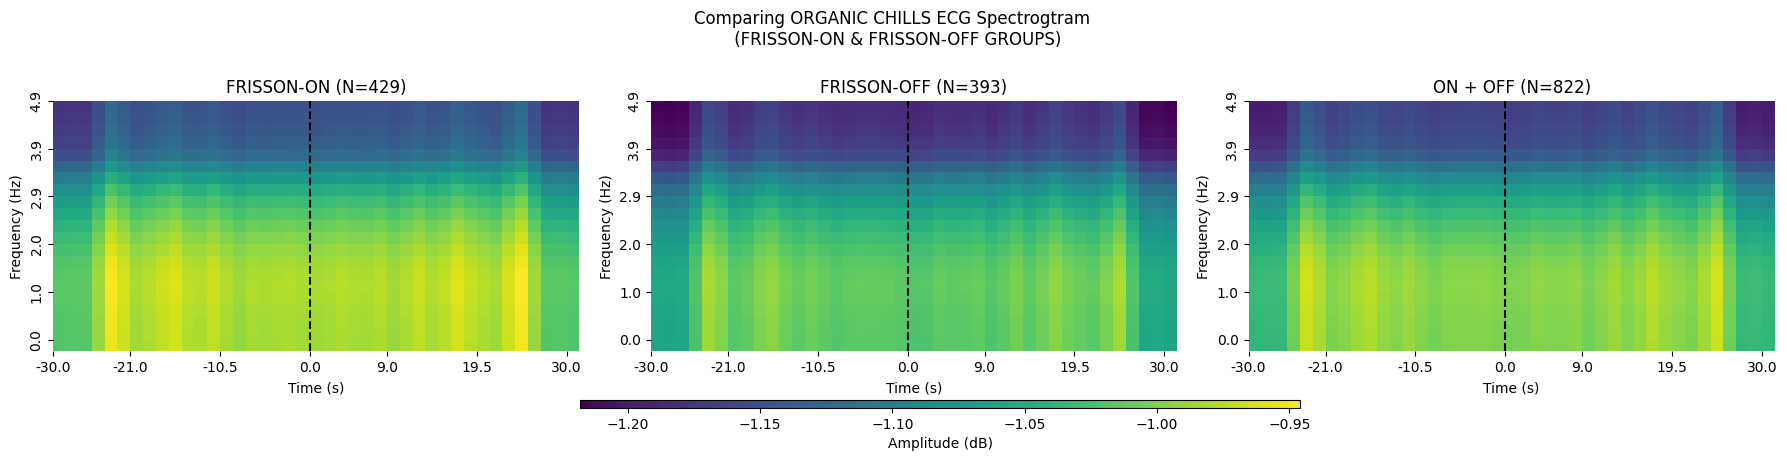

In [ ]:
frequencies = np.linspace(SFT.f[freqs][0], SFT.f[freqs][-1], frisson_stft.shape[0])
n_time = frisson_stft.shape[2]
time = np.linspace(-30, 30, n_time)


fig, ax = plt.subplots(1, 3, figsize=(18, 4))
ch = select_channel["ecg"]

vmin = min(np.min(frisson_on_stft[:, ch, :]), np.min(frisson_off_stft[:, ch, :]), np.min(frisson_stft[:, ch, :]))
vmax = max(np.max(frisson_on_stft[:, ch, :]), np.max(frisson_off_stft[:, ch, :]), np.max(frisson_stft[:, ch, :]))

# Plot each heatmap
for i, data in enumerate([frisson_on_stft, frisson_off_stft, frisson_stft]):
    heatmap = sns.heatmap(data[::-1, ch, :], cmap="viridis", ax=ax[i],
                xticklabels=50, yticklabels=20,
                vmin=vmin, vmax=vmax, cbar=False)  # Adjust tick frequency here
    if i==2:
      heatmap_mesh = heatmap

    ax[i].set_xlabel("Time (s)")
    ax[i].set_ylabel("Frequency (Hz)")

    # Set custom tick labels
    xticks = np.linspace(0, n_time - 1, 7).astype(int)
    ax[i].set_xticks(xticks)
    ax[i].set_xticklabels(np.round(time[xticks], 1))

    yticks = np.linspace(0, len(frequencies) - 1, 6).astype(int)
    ax[i].set_yticks(yticks)
    ax[i].set_yticklabels(np.round(frequencies[::-1][yticks], 1))  # reversed!

    ax[i].axvline(data.shape[2]//2, color="black", linestyle="--", label="Chills Report")

cax = fig.add_axes([0.325, 0.005, 0.4, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(heatmap_mesh.collections[0], cax=cax, orientation="horizontal")
cbar.set_label("Amplitude (dB)")

ax[0].set_title(f"FRISSON-ON (N={len(frisson_on)})")
ax[1].set_title(f"FRISSON-OFF (N={len(frisson_off)})")
ax[2].set_title(f"ON + OFF (N={len(frisson)})")
fig.suptitle("Comparing ORGANIC CHILLS ECG Spectrogtram \n (FRISSON-ON & FRISSON-OFF GROUPS)", y=1.00)
fig.tight_layout()
plt.savefig("plots/physiological_analysis/ORGANIC_CHILLS_COMPARISON_ECG_TF_DOMAIN.png", dpi=300, bbox_inches="tight")

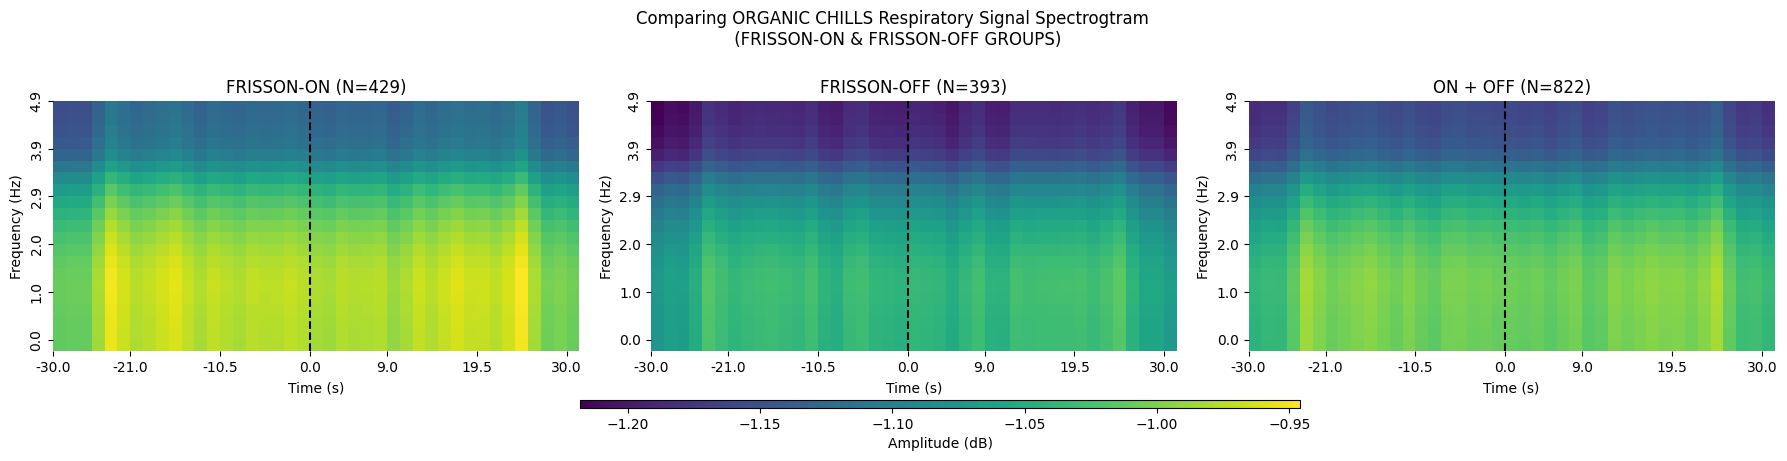

In [ ]:
frequencies = np.linspace(SFT.f[freqs][0], SFT.f[freqs][-1], frisson_stft.shape[0])
n_time = frisson_stft.shape[2]
time = np.linspace(-30, 30, n_time)

fig, ax = plt.subplots(1, 3, figsize=(18, 4))
ch = select_channel["resp"]

vmin = min(np.min(frisson_on_stft[:, ch, :]), np.min(frisson_off_stft[:, ch, :]), np.min(frisson_stft[:, ch, :]))
vmax = max(np.max(frisson_on_stft[:, ch, :]), np.max(frisson_off_stft[:, ch, :]), np.max(frisson_stft[:, ch, :]))

# Plot each heatmap
for i, data in enumerate([frisson_on_stft, frisson_off_stft, frisson_stft]):
    heatmap = sns.heatmap(data[::-1, ch, :], cmap="viridis", ax=ax[i],
                xticklabels=50, yticklabels=20,
                vmin=vmin, vmax=vmax, cbar=False)  # Adjust tick frequency here

    if i==2:
      heatmpa_mesh = heatmap

    ax[i].set_xlabel("Time (s)")
    ax[i].set_ylabel("Frequency (Hz)")

    # Set custom tick labels
    xticks = np.linspace(0, n_time - 1, 7).astype(int)
    ax[i].set_xticks(xticks)
    ax[i].set_xticklabels(np.round(time[xticks], 1))

    yticks = np.linspace(0, len(frequencies) - 1, 6).astype(int)
    ax[i].set_yticks(yticks)
    ax[i].set_yticklabels(np.round(frequencies[::-1][yticks], 1))  # reversed!

    ax[i].axvline(data.shape[2]//2, color="black", linestyle="--", label="Chills Report")

cax = fig.add_axes([0.325, 0.005, 0.4, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(heatmap_mesh.collections[0], cax=cax, orientation="horizontal")
cbar.set_label("Amplitude (dB)")

ax[0].set_title(f"FRISSON-ON (N={len(frisson_on)})")
ax[1].set_title(f"FRISSON-OFF (N={len(frisson_off)})")
ax[2].set_title(f"ON + OFF (N={len(frisson)})")
fig.suptitle("Comparing ORGANIC CHILLS Respiratory Signal Spectrogtram \n (FRISSON-ON & FRISSON-OFF GROUPS)", y=1.00)
fig.tight_layout()
plt.savefig("plots/physiological_analysis/ORGANIC_CHILLS_COMPARISON_Resp_TF_DOMAIN.png", dpi=300, bbox_inches="tight")

### Subset 2

In [ ]:
window = 0.01
organic_epochs = np.vstack((frisson_on_epochs, frisson_off_epochs))
non_chill_epochs = np.vstack((pre_rest_epochs, post_rest_epochs))

organic =  np.apply_along_axis(lambda x: m_avg(x, window), axis=1, arr=organic_epochs)
non_chill = np.apply_along_axis(lambda x: m_avg(x, window), axis=1, arr=non_chill_epochs)

organic = minmax_scale(organic, 1)
non_chill = minmax_scale(non_chill, 1)

organic.shape, non_chill.shape

((822, 30000, 4), (650, 30000, 4))

#### Time Domain

In [ ]:
organic_mean = np.mean(organic, axis=0)
non_chill_mean = np.mean(non_chill, axis=0)

organic_std = np.std(organic, axis=0) / len(organic)**0.5
non_chill_std = np.std(non_chill, axis=0) / len(non_chill)**0.5

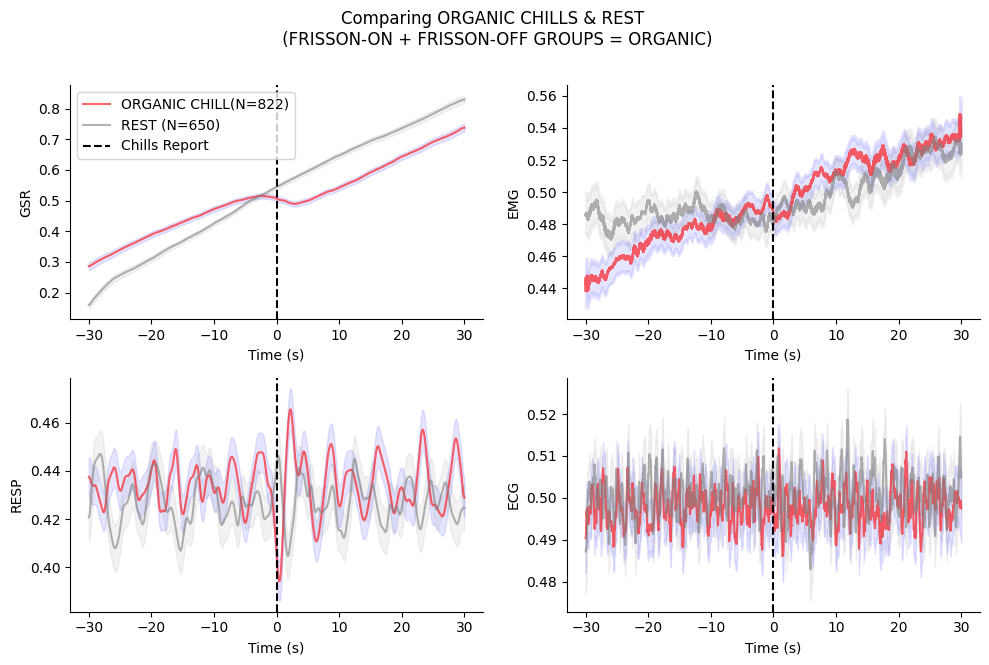

In [ ]:
fig, ax_ = plt.subplots(2, 2, figsize=(10, 6))
ax = ax_.flatten()

for sensor in ["gsr", "emg", "resp", "ecg"]:
  ch = select_channel[sensor]

  y = organic_mean[:, ch].T
  y_std = organic_std[:, ch]
  ax[ch].plot(np.arange(-30, 30, 1/fs), y, label=f"ORGANIC CHILL(N={len(organic)})", color=(1, 0, 0, 0.6))
  ax[ch].fill_between(np.arange(-30, 30, 1/fs), y - y_std, y + y_std, color=(0, 0, 1, 0.1))

  y = non_chill_mean[:, ch].T
  y_std = non_chill_std[:, ch]
  ax[ch].plot(np.arange(-30, 30, 1/fs), y, label=f"REST (N={len(non_chill)})", color=(0.5, 0.5, 0.5, 0.6))
  ax[ch].fill_between(np.arange(-30, 30, 1/fs), y - y_std, y + y_std, color=(0.5, 0.5, 0.5, 0.1))

  ax[ch].spines["top"].set_visible(False)
  ax[ch].spines["right"].set_visible(False)

  # plt.axvline(0, color="black", linestyle="--", label="baseline")
  ax[ch].axvline(0, color="black", linestyle="--", label="Chills Report")

  # ax[ch].yticks([])
  # ax[ch].set_title(f"{sensor}", y=1.05)
  ax[ch].set_xlabel("Time (s)")
  ax[ch].set_ylabel(sensor.upper())

  if ch==0:
    ax[ch].legend(loc="upper left")
  ax[ch].grid(False)

fig.tight_layout()
fig.suptitle("Comparing ORGANIC CHILLS & REST \n (FRISSON-ON + FRISSON-OFF GROUPS = ORGANIC)", y=1.1)
plt.savefig("plots/physiological_analysis/ORGANIC_REST_COMPARISON_TIME_DOMAIN.png", dpi=300, bbox_inches="tight")

#### Time-Frequency Domain

In [ ]:
from scipy.signal.windows import hann
from scipy.signal import ShortTimeFFT

window = hann(128, sym=False)
hop_ = 2*int(0.025*fs*PLOT_TIME_WINDOW)
nfft = 2048

SFT = ShortTimeFFT(window, hop_, fs, mfft=nfft, scale_to="magnitude")
freqs = (SFT.f>=0) & (SFT.f<=5)
n_freqs = len(SFT.f[freqs])
n_times = int(2*fs*PLOT_TIME_WINDOW / hop_) + 1
print(n_freqs, n_times)

21 41


In [ ]:
from scipy.ndimage import gaussian_filter

organic_stft = np.empty((len(organic), n_freqs, 4, n_times))
non_chill_stft = np.empty((len(non_chill), n_freqs, 4, n_times))

for e, epoch in tqdm(enumerate(organic), total=len(organic)):
  Sxx = SFT.spectrogram(organic[e,::], axis=0)
  organic_stft[e,::] = 10*np.log10(np.fmax(Sxx, 1E-4))[freqs,::]

for e, epoch in tqdm(enumerate(non_chill), total=len(non_chill)):
  Sxx = SFT.spectrogram(non_chill[e,::], axis=0)
  non_chill_stft[e,::] = 10*np.log10(np.fmax(Sxx, 1E-4))[freqs,::]

organic_stft = organic_stft.mean(axis=0)
non_chill_stft = non_chill_stft.mean(axis=0)

sigma_ = [42, 0, 42]
order_ = [210, 0, 210]
organic_stft = gaussian_filter(organic_stft, sigma=sigma_, order=order_) * 1E271
non_chill_stft = gaussian_filter(non_chill_stft, sigma=sigma_, order=order_)*1E271

100%|██████████| 650/650 [00:14<00:00, 45.60it/s]


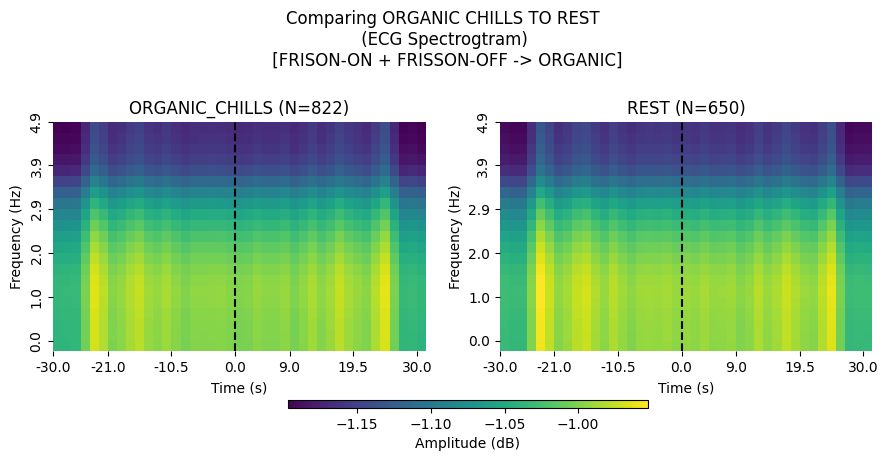

In [ ]:
frequencies = np.linspace(SFT.f[freqs][0], SFT.f[freqs][-1], frisson_stft.shape[0])
n_time = frisson_stft.shape[2]
time = np.linspace(-30, 30, n_time)

fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ch = select_channel["ecg"]

vmin = min(np.min(organic_stft[:, ch, :]), np.min(non_chill_stft[:, ch, :]))
vmax = max(np.max(organic_stft[:, ch, :]), np.max(non_chill_stft[:, ch, :]))

# Plot each heatmap
for i, data in enumerate([organic_stft, non_chill_stft]):
    heatmap = sns.heatmap(data[::-1, ch, :], cmap="viridis", ax=ax[i],
                xticklabels=50, yticklabels=20,
                vmin=vmin, vmax=vmax, cbar=False)
    if i==1:
      heatmap_mesh = heatmap

    ax[i].set_xlabel("Time (s)")
    ax[i].set_ylabel("Frequency (Hz)")

    # Set custom tick labels
    xticks = np.linspace(0, n_time - 1, 7).astype(int)
    ax[i].set_xticks(xticks)
    ax[i].set_xticklabels(np.round(time[xticks], 1))

    yticks = np.linspace(0, len(frequencies) - 1, 6).astype(int)
    ax[i].set_yticks(yticks)
    ax[i].set_yticklabels(np.round(frequencies[::-1][yticks], 1))  # reversed!

    ax[i].axvline(data.shape[2]//2, color="black", linestyle="--", label="Chills Report")

cax = fig.add_axes([0.325, 0.005, 0.4, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(heatmap_mesh.collections[0], cax=cax, orientation="horizontal")
cbar.set_label("Amplitude (dB)")

ax[0].set_title(f"ORGANIC_CHILLS (N={len(organic)})")
ax[1].set_title(f"REST (N={len(non_chill)})")
fig.suptitle("Comparing ORGANIC CHILLS TO REST \n (ECG Spectrogtram) \n [FRISON-ON + FRISSON-OFF -> ORGANIC]", y=1.00)
fig.tight_layout()
plt.savefig("plots/physiological_analysis/ORGANIC_REST_COMPARISON_ECG_TF_DOMAIN.png", dpi=300, bbox_inches="tight")

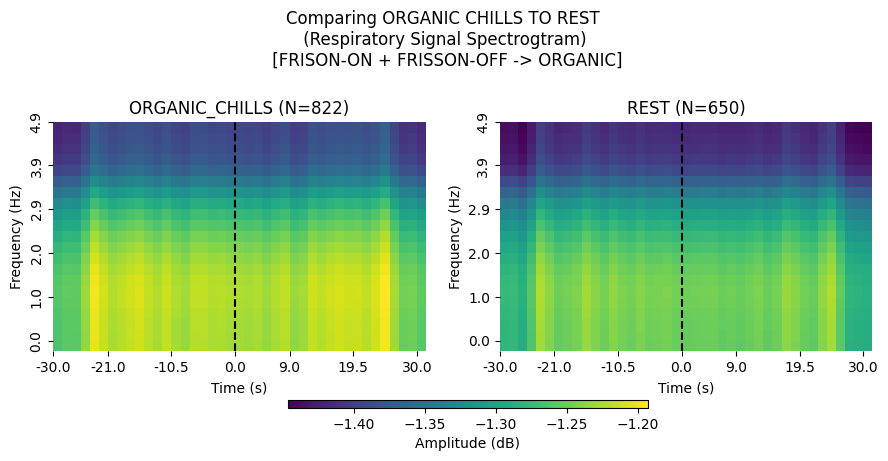

In [ ]:
frequencies = np.linspace(SFT.f[freqs][0], SFT.f[freqs][-1], frisson_stft.shape[0])
n_time = frisson_stft.shape[2]
time = np.linspace(-30, 30, n_time)

fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ch = select_channel["resp"]

vmin = min(np.min(organic_stft[:, ch, :]), np.min(non_chill_stft[:, ch, :]))
vmax = max(np.max(organic_stft[:, ch, :]), np.max(non_chill_stft[:, ch, :]))

# Plot each heatmap
for i, data in enumerate([organic_stft, non_chill_stft]):
    heatmap = sns.heatmap(data[::-1, ch, :], cmap="viridis", ax=ax[i],
                xticklabels=50, yticklabels=20,
                vmin=vmin, vmax=vmax, cbar=False)

    if i==1:
      heatmap_mesh = heatmap

    ax[i].set_xlabel("Time (s)")
    ax[i].set_ylabel("Frequency (Hz)")

    # Set custom tick labels
    xticks = np.linspace(0, n_time - 1, 7).astype(int)
    ax[i].set_xticks(xticks)
    ax[i].set_xticklabels(np.round(time[xticks], 1))

    yticks = np.linspace(0, len(frequencies) - 1, 6).astype(int)
    ax[i].set_yticks(yticks)
    ax[i].set_yticklabels(np.round(frequencies[::-1][yticks], 1))  # reversed!

    ax[i].axvline(data.shape[2]//2, color="black", linestyle="--", label="Chills Report")

cax = fig.add_axes([0.325, 0.005, 0.4, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(heatmap_mesh.collections[0], cax=cax, orientation="horizontal")
cbar.set_label("Amplitude (dB)")

ax[0].set_title(f"ORGANIC_CHILLS (N={len(organic)})")
ax[1].set_title(f"REST (N={len(non_chill)})")
fig.suptitle("Comparing ORGANIC CHILLS TO REST \n (Respiratory Signal Spectrogtram) \n [FRISON-ON + FRISSON-OFF -> ORGANIC]", y=1.00)
fig.tight_layout()
plt.savefig("plots/physiological_analysis/ORGANIC_REST_COMPARISON_RESP_TF_DOMAIN.png", dpi=300, bbox_inches="tight")

### Subset 3

In [ ]:
window = 0.01
organic_epochs = np.vstack((frisson_on_epochs, frisson_off_epochs))

organic =  np.apply_along_axis(lambda x: m_avg(x, window), axis=1, arr=organic_epochs)
augmented = np.apply_along_axis(lambda x: m_avg(x, window), axis=1, arr=augmented_epochs)
simulated = np.apply_along_axis(lambda x: m_avg(x, window), axis=1, arr=simulated_epochs)

organic = minmax_scale(organic, 1)
augmented = minmax_scale(augmented, 1)
simulated = minmax_scale(simulated, 1)

organic.shape, augmented.shape, simulated.shape

((822, 30000, 4), (6, 30000, 4), (36, 30000, 4))

#### Time Domain

In [ ]:
organic_mean = np.mean(organic, axis=0)
augmented_mean = np.mean(augmented, axis=0)
simulated_mean = np.mean(simulated, axis=0)


organic_std = np.std(organic, axis=0) / len(organic)**0.5
augmented_std = np.std(augmented, axis=0) / len(augmented)**0.5
simulated_std = np.std(simulated, axis=0) / len(simulated)**0.5

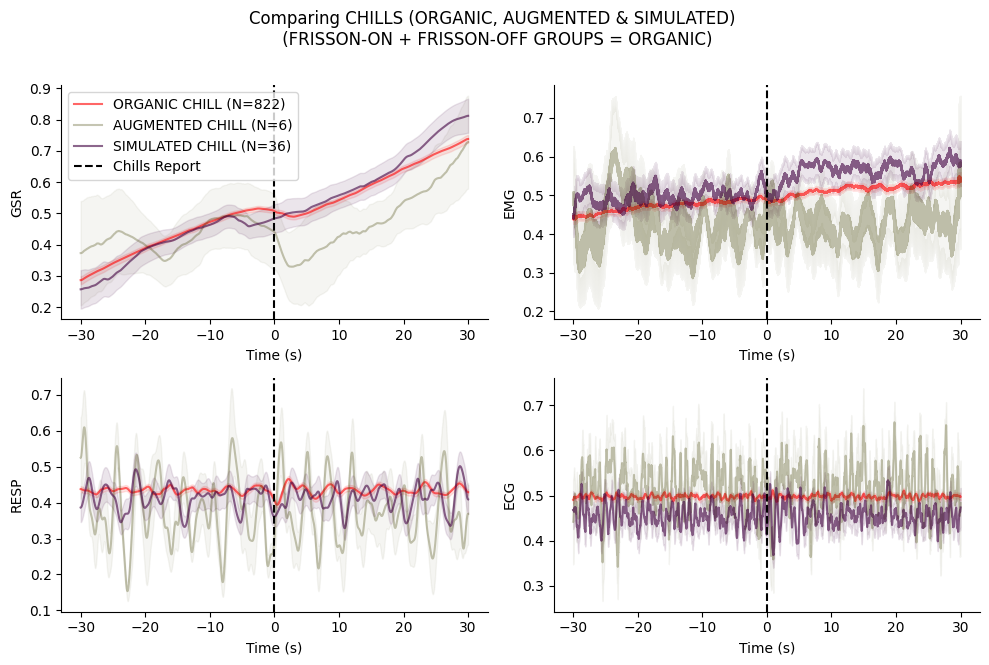

In [ ]:
fig, ax_ = plt.subplots(2, 2, figsize=(10, 6))
ax = ax_.flatten()

for sensor in ["gsr", "emg", "resp", "ecg"]:
  ch = select_channel[sensor]

  y = organic_mean[:, ch].T
  y_std = organic_std[:, ch]
  ax[ch].plot(np.arange(-30, 30, 1/fs), y, label=f"ORGANIC CHILL (N={len(organic)})", color=(1, 0, 0, 0.6))
  ax[ch].fill_between(np.arange(-30, 30, 1/fs), y - y_std, y + y_std, color=(1, 0, 0, 0.1))

  y = augmented_mean[:, ch].T
  y_std = augmented_std[:, ch]
  ax[ch].plot(np.arange(-30, 30, 1/fs), y, label=f"AUGMENTED CHILL (N={len(augmented)})", color=(0.25, 0.25, 0, 0.3))
  ax[ch].fill_between(np.arange(-30, 30, 1/fs), y - y_std, y + y_std, color=(0.25, 0.25, 0, 0.05))

  y = simulated_mean[:, ch].T
  y_std = simulated_std[:, ch]
  ax[ch].plot(np.arange(-30, 30, 1/fs), y, label=f"SIMULATED CHILL (N={len(simulated)})", color=(0.25, 0, 0.25, 0.6))
  ax[ch].fill_between(np.arange(-30, 30, 1/fs), y - y_std, y + y_std, color=(0.25, 0, 0.25, 0.1))

  ax[ch].spines["top"].set_visible(False)
  ax[ch].spines["right"].set_visible(False)

  # plt.axvline(0, color="black", linestyle="--", label="baseline")
  ax[ch].axvline(0, color="black", linestyle="--", label="Chills Report")

  # ax[ch].yticks([])
  # ax[ch].set_title(f"{sensor}", y=1.05)
  ax[ch].set_xlabel("Time (s)")
  ax[ch].set_ylabel(sensor.upper())

  if ch==0:
    ax[ch].legend(loc="upper left")
  ax[ch].grid(False)

fig.tight_layout()
fig.suptitle("Comparing CHILLS (ORGANIC, AUGMENTED & SIMULATED) \n (FRISSON-ON + FRISSON-OFF GROUPS = ORGANIC)", y=1.1)
plt.savefig("plots/physiological_analysis/CHILLS_COMPARISON_TIME_DOMAIN.png", dpi=300, bbox_inches="tight")

#### Time-Frequency Domain

In [ ]:
from scipy.signal.windows import hann
from scipy.signal import ShortTimeFFT

window = hann(128, sym=False)
hop_ = 2*int(0.025*fs*PLOT_TIME_WINDOW)
nfft = 2048

SFT = ShortTimeFFT(window, hop_, fs, mfft=nfft, scale_to="magnitude")
freqs = (SFT.f>=0) & (SFT.f<=5)
n_freqs = len(SFT.f[freqs])
n_times = int(2*fs*PLOT_TIME_WINDOW / hop_) + 1
print(n_freqs, n_times)

21 41


In [ ]:
from scipy.ndimage import gaussian_filter

organic_stft = np.empty((len(organic), n_freqs, 4, n_times))
augmented_stft = np.empty((len(augmented), n_freqs, 4, n_times))
simulated_stft = np.empty((len(simulated), n_freqs, 4, n_times))

for e, epoch in tqdm(enumerate(organic), total=len(organic)):
  Sxx = SFT.spectrogram(organic[e,::], axis=0)
  organic_stft[e,::] = 10*np.log10(np.fmax(Sxx, 1E-4))[freqs,::]

for e, epoch in tqdm(enumerate(augmented), total=len(augmented)):
  Sxx = SFT.spectrogram(augmented[e,::], axis=0)
  augmented_stft[e,::] = 10*np.log10(np.fmax(Sxx, 1E-4))[freqs,::]

for e, epoch in tqdm(enumerate(simulated), total=len(simulated)):
  Sxx = SFT.spectrogram(simulated[e,::], axis=0)
  simulated_stft[e,::] = 10*np.log10(np.fmax(Sxx, 1E-4))[freqs,::]

organic_stft = organic_stft.mean(axis=0)
augmented_stft = augmented_stft.mean(axis=0)
simulated_stft = simulated_stft.mean(axis=0)

sigma_ = [42, 0, 42]
order_ = [210, 0, 210]
organic_stft = gaussian_filter(organic_stft, sigma=sigma_, order=order_) * 1E271
augmented_stft = gaussian_filter(augmented_stft, sigma=sigma_, order=order_) * 1E271
simulated_stft = gaussian_filter(simulated_stft, sigma=sigma_, order=order_) * 1E271

100%|██████████| 36/36 [00:00<00:00, 37.64it/s]


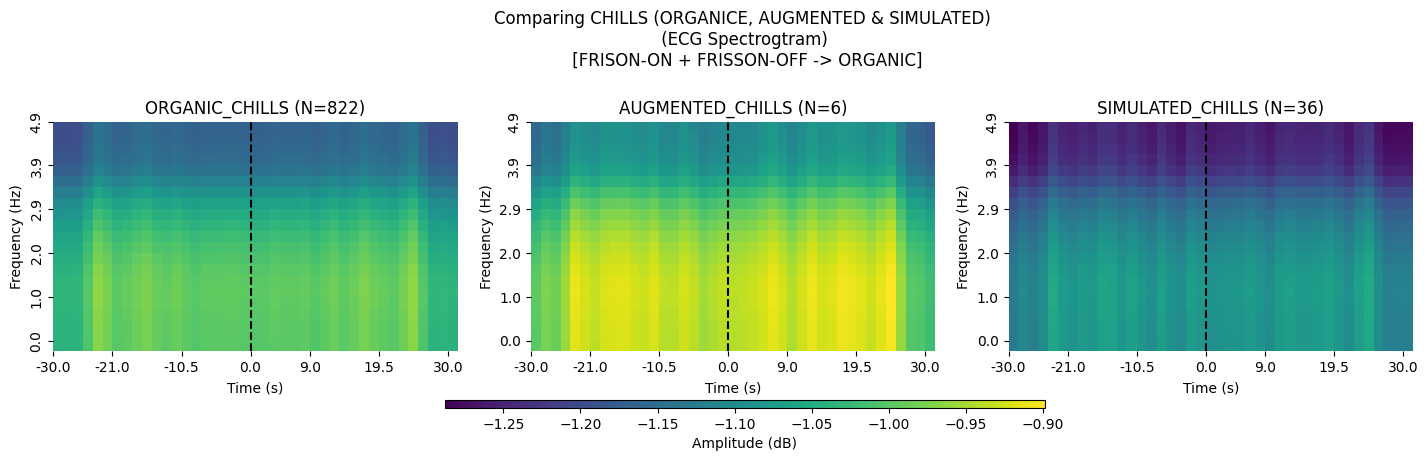

In [ ]:
frequencies = np.linspace(SFT.f[freqs][0], SFT.f[freqs][-1], frisson_stft.shape[0])
n_time = frisson_stft.shape[2]
time = np.linspace(-30, 30, n_time)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ch = select_channel["ecg"]

vmin = min(np.min(organic_stft[:, ch, :]), np.min(augmented_stft[:, ch, :]), np.min(simulated_stft[:, ch, :]))
vmax = max(np.max(organic_stft[:, ch, :]), np.max(augmented_stft[:, ch, :]), np.max(simulated_stft[:, ch, :]))

# Plot each heatmap
for i, data in enumerate([organic_stft, augmented_stft, simulated_stft]):
    heatmap = sns.heatmap(data[::-1, ch, :], cmap="viridis", ax=ax[i],
                xticklabels=50, yticklabels=20,
                vmin=vmin, vmax=vmax, cbar=False)

    if i == 2:
      heatmap_mesh = heatmap  # store the QuadMesh from the last heatmap for the colorbar

    ax[i].set_xlabel("Time (s)")
    ax[i].set_ylabel("Frequency (Hz)")

    # Set custom tick labels
    xticks = np.linspace(0, n_time - 1, 7).astype(int)
    ax[i].set_xticks(xticks)
    ax[i].set_xticklabels(np.round(time[xticks], 1))

    yticks = np.linspace(0, len(frequencies) - 1, 6).astype(int)
    ax[i].set_yticks(yticks)
    ax[i].set_yticklabels(np.round(frequencies[::-1][yticks], 1))  # reversed!

    ax[i].axvline(data.shape[2]//2, color="black", linestyle="--", label="Chills Report")

cax = fig.add_axes([0.3, 0.005, 0.4, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(heatmap_mesh.collections[0], cax=cax, orientation="horizontal")
cbar.set_label("Amplitude (dB)")

ax[0].set_title(f"ORGANIC_CHILLS (N={len(organic)})")
ax[1].set_title(f"AUGMENTED_CHILLS (N={len(augmented)})")
ax[2].set_title(f"SIMULATED_CHILLS (N={len(simulated)})")
fig.suptitle("Comparing CHILLS (ORGANICE, AUGMENTED & SIMULATED) \n (ECG Spectrogtram) \n [FRISON-ON + FRISSON-OFF -> ORGANIC]", y=1.00)
fig.tight_layout(rect=[0, 0, 0.96, 1])
plt.savefig("plots/physiological_analysis/CHILLS_COMPARISON_ECG_TF_DOMAIN.png", dpi=300, bbox_inches="tight")

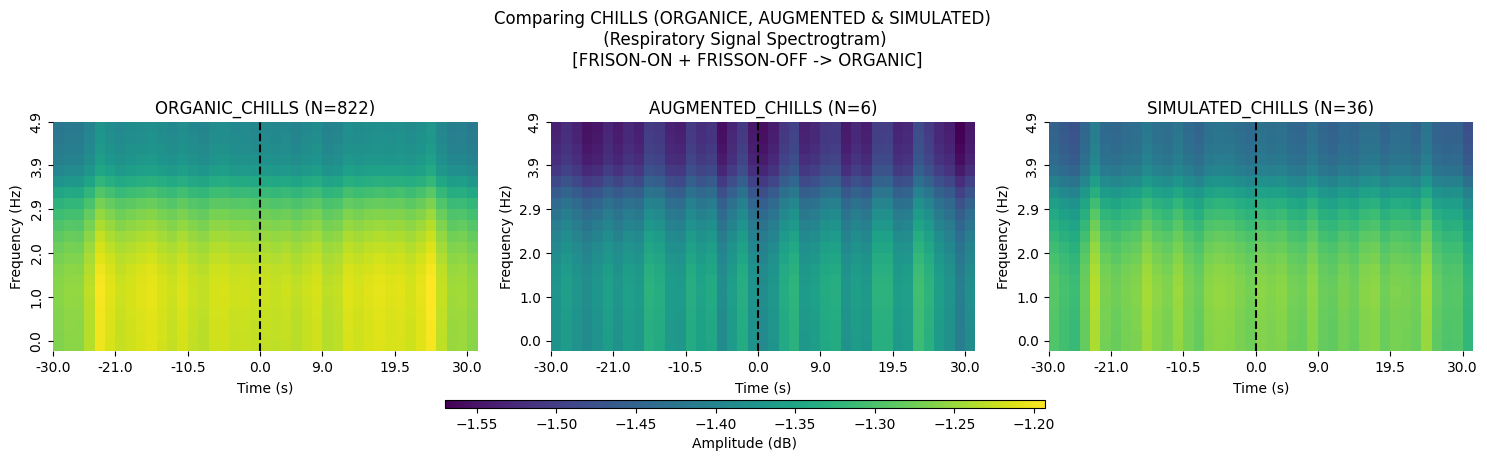

In [ ]:
frequencies = np.linspace(SFT.f[freqs][0], SFT.f[freqs][-1], frisson_stft.shape[0])
n_time = frisson_stft.shape[2]
time = np.linspace(-30, 30, n_time)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ch = select_channel["resp"]

vmin = min(np.min(organic_stft[:, ch, :]), np.min(augmented_stft[:, ch, :]), np.min(simulated_stft[:, ch, :]))
vmax = max(np.max(organic_stft[:, ch, :]), np.max(augmented_stft[:, ch, :]), np.max(simulated_stft[:, ch, :]))

# Plot each heatmap
for i, data in enumerate([organic_stft, augmented_stft, simulated_stft]):
    heatmap = sns.heatmap(data[::-1, ch, :], cmap="viridis", ax=ax[i],
                xticklabels=50, yticklabels=20,
                vmin=vmin, vmax=vmax, cbar=False)

    if i==2:
      heatmap_mesh = heatmap

    ax[i].set_xlabel("Time (s)")
    ax[i].set_ylabel("Frequency (Hz)")

    # Set custom tick labels
    xticks = np.linspace(0, n_time - 1, 7).astype(int)
    ax[i].set_xticks(xticks)
    ax[i].set_xticklabels(np.round(time[xticks], 1))

    yticks = np.linspace(0, len(frequencies) - 1, 6).astype(int)
    ax[i].set_yticks(yticks)
    ax[i].set_yticklabels(np.round(frequencies[::-1][yticks], 1))  # reversed!

    ax[i].axvline(data.shape[2]//2, color="black", linestyle="--", label="Chills Report")

cax = fig.add_axes([0.3, 0.005, 0.4, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(heatmap_mesh.collections[0], cax=cax, orientation="horizontal")
cbar.set_label("Amplitude (dB)")

ax[0].set_title(f"ORGANIC_CHILLS (N={len(organic)})")
ax[1].set_title(f"AUGMENTED_CHILLS (N={len(augmented)})")
ax[2].set_title(f"SIMULATED_CHILLS (N={len(simulated)})")
fig.suptitle("Comparing CHILLS (ORGANICE, AUGMENTED & SIMULATED) \n (Respiratory Signal Spectrogtram) \n [FRISON-ON + FRISSON-OFF -> ORGANIC]", y=1.00)
fig.tight_layout()
plt.savefig("plots/physiological_analysis/CHILLS_COMPARISON_Resp_TF_DOMAIN.png", dpi=300, bbox_inches="tight")

# Download Artifacts

In [ ]:
shutil.make_archive("plots_physiological_analysis", 'zip', "plots")
files.download("plots_physiological_analysis.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>